In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

100% 28.7G/28.7G [22:58<00:00, 30.5MB/s]
100% 28.7G/28.7G [22:58<00:00, 22.4MB/s]


In [ ]:
!mkdir data

In [ ]:
!unzip h-and-m-personalized-fashion-recommendations.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/images/089/0890677001.jpg  
  inflating: data/images/089/0890677002.jpg  
  inflating: data/images/089/0890677004.jpg  
  inflating: data/images/089/0890683001.jpg  
  inflating: data/images/089/0890683002.jpg  
  inflating: data/images/089/0890684001.jpg  
  inflating: data/images/089/0890684002.jpg  
  inflating: data/images/089/0890686002.jpg  
  inflating: data/images/089/0890697001.jpg  
  inflating: data/images/089/0890697002.jpg  
  inflating: data/images/089/0890700001.jpg  
  inflating: data/images/089/0890717001.jpg  
  inflating: data/images/089/0890717002.jpg  
  inflating: data/images/089/0890717003.jpg  
  inflating: data/images/089/0890722001.jpg  
  inflating: data/images/089/0890722002.jpg  
  inflating: data/images/089/0890734001.jpg  
  inflating: data/images/089/0890734003.jpg  
  inflating: data/images/089/0890741001.jpg  
  inflating: data/images/089/0890745001.jpg  
  inflating: data/images/089/

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q scann

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import tempfile
import matplotlib.pyplot as plt #for ploting the images
from pathlib import Path
from typing import Dict, Text
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_dir = Path('data')
train0 = pd.read_csv(data_dir/'transactions_train.csv', dtype=str, usecols=['customer_id', 'article_id']) # taking customers and the article ids they bought
train0.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004


In [ ]:
customer_df = pd.read_csv(data_dir/'customers.csv', dtype=str, usecols=['customer_id'])
customer_df.head()

,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [ ]:
article_df = pd.read_csv(data_dir/'articles.csv', dtype=str, usecols=['article_id'])
article_df.head()

,article_id
0,0108775015
1,0108775044
2,0108775051
3,0110065001
4,0110065002


In [ ]:
# Creating a tensorflow dataset from the article_ds dataframe where each element of the article_ds is an article id
article_ds = tf.data.Dataset.from_tensor_slices(dict(article_df[['article_id']]))
articles = article_ds.map(lambda x: x['article_id'])
articles

<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

The customer model (aka the query model) is used for making the customer embeddings

The article model (aka the candidate model) is used for making the article embeddings

In [ ]:
embedding_dimension = 64 #since we wanted embeddings of dimension 64 and also because it's given in the documnetation :)

# Query Model (query is the customer for whom we want the recommendations)
customer_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=customer_df.customer_id.values, mask_token=None),  # maps each customer_id to a numerical index/value
  tf.keras.layers.Embedding(len(customer_df) + 1, embedding_dimension) # this is the embedding layer, which makes embeddings for the customer_id values obtained from the provious layer and +1 is foe out of vocabulary items
])

In [ ]:
# Candidate Model
article_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=article_df.article_id.values, mask_token=None), # maps each article_id to a numerical index/value
  tf.keras.layers.Embedding(len(article_df) + 1, embedding_dimension) # makes embeddings corresponding to each article_id
])

In [ ]:
# Retrieval Model
# we are basically defining the retrieval model which will be used while training/fitting the model to the data
class HandMModel(tfrs.Model):

    def __init__(self, customer_model, article_model):
        super().__init__()
        self.article_model: tf.keras.Model = article_model # it takes the candidate/article model for later use
        self.customer_model: tf.keras.Model = customer_model # it takes the query/customer model for later use
        self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=articles.batch(128).map(self.article_model), # devides the candidates into batches of 128 for getting the top k from them
            ),
        )

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:

        customer_embeddings = self.customer_model(features["customer_id"])
        article_embeddings = self.article_model(features["article_id"])

        # The task computes the loss and the metrics.
        return self.task(customer_embeddings, article_embeddings,compute_metrics=not training)

In [ ]:
model = HandMModel(customer_model, article_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [ ]:
train_size = int(0.8 *len(train0))

In [ ]:
train = train0[:train_size]
test = train0[train_size:]

train_ds = tf.data.Dataset.from_tensor_slices(dict(train[['customer_id','article_id']])).shuffle(100_000).batch(256).cache()
test_ds = tf.data.Dataset.from_tensor_slices(dict(test[['customer_id','article_id']])).batch(256).cache()

num_epochs = 5 # no of iterations
history = model.fit(
    train_ds,
    validation_data = test_ds,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

Epoch 1/5
99339/99339 [==============================] - 1101s 11ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1226.4652 - regularization_loss: 0.0000e+00 - total_loss: 1226.4652
Epoch 2/5
99339/99339 [==============================] - 535s 5ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 999.6988 - regularization_loss: 0.0000e+00 - total_loss: 999.6988
Epoch 3/5
99339/99339 [==============================] - 539s 5ms/step - factorized_top_k/top_1_categorical_accuracy: 

Our candidate model gives us the customer embeddings since query is basically a customer_id while the query model generates the embeddings corresponding to the articles. Since we apply the models on the entire dataset, so we get the embeddings for each customer and article. We save them in separate pickle files.

In [ ]:
article_embeds = article_model.predict(article_df)
customer_embeds = customer_model.predict(customer_df)

42875/42875 [==============================] - 576s 13ms/step


In [ ]:
type(article_embeds)

numpy.ndarray

In [ ]:
article_embeds.shape

(105542, 64)

In [ ]:
article_embeds[0]

array([ 0.03372762,  0.04346215, -0.00292798, -0.00564713, -0.00809741,
       -0.03214791, -0.02283555,  0.04532296, -0.03726941, -0.01857884,
        0.01329661, -0.04804971, -0.00216045, -0.00278108,  0.03836563,
        0.04700672, -0.04435735, -0.0038687 , -0.00846573,  0.01584275,
       -0.01611317,  0.03316612,  0.00168042,  0.01332514,  0.02325337,
       -0.0208052 , -0.00542984,  0.01811441, -0.00028386,  0.01989229,
        0.01690514, -0.04241803,  0.03726529, -0.03926422,  0.03901321,
        0.01862636, -0.03092439, -0.04668725, -0.03354665,  0.01535023,
        0.00505228,  0.00578547,  0.00021987, -0.01104229, -0.00892862,
       -0.00958773, -0.02777963, -0.00496017, -0.0052323 ,  0.01592997,
        0.03751478,  0.04910375, -0.03569701,  0.00991736, -0.04625943,
       -0.00932632,  0.0074296 ,  0.03053341, -0.01778746,  0.0405525 ,
       -0.01759492, -0.04402469,  0.01755441, -0.04439397], dtype=float32)

In [ ]:
type(customer_embeds)

numpy.ndarray

In [ ]:
customer_embeds.shape

(1371980, 1, 64)

In [ ]:
customer_embeds[0]

array([[-0.03906878,  0.03739606,  0.00452178, -0.01963198,  0.04061187,
         0.02205892, -0.02120273, -0.03220475, -0.02118907,  0.02958143,
        -0.03325085,  0.02319809,  0.00619616, -0.01616676, -0.0027289 ,
         0.03358108, -0.03635596, -0.00454022, -0.00177866,  0.03518797,
        -0.02455488, -0.03536192, -0.02810879,  0.04029812,  0.01290763,
        -0.02745735, -0.01436196, -0.04872563,  0.01828028, -0.02683188,
        -0.04646566, -0.01694275,  0.04627481, -0.04315228, -0.04979029,
        -0.01706712,  0.03725792,  0.03007797,  0.01469007, -0.02221725,
        -0.00806   ,  0.01661042,  0.01952608, -0.01204342, -0.02915623,
         0.02841501,  0.0297861 , -0.02127284,  0.04391703, -0.00663888,
        -0.01708062,  0.03777776, -0.04346565, -0.00832664,  0.02321823,
        -0.01046528,  0.04676085,  0.01957495, -0.02571346, -0.02128283,
         0.03045089,  0.03833306,  0.00080712, -0.004155  ]],
      dtype=float32)

In [ ]:
import pickle
with open('customer_embeds.pickle', 'wb') as f:
    pickle.dump(customer_embeds, f)

with open('article_embeds.pickle', 'wb') as f:
    pickle.dump(article_embeds, f)

In [ ]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.customer_model, k = 20 )
scann_index.index_from_dataset(
  tf.data.Dataset.zip((articles.batch(100), articles.batch(100).map(model.article_model)))
)

In [ ]:
import pickle
with open('model.pickle', 'wb') as f:
    pickle.dump(scann_index, f)

ValueError: ignored

In [ ]:
def plot_items(items):
    path = "data/images"

    k = len(items)
    fig = plt.figure(figsize=(3*k, 10))
    for item, i in zip(items, range(1, k+1)):
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, k, i)
        plt.axis('off')
        plt.imshow(image)

In [ ]:
sample = train0.iloc[11:12]
prev_items = train0[train0.customer_id == sample.customer_id.values[0]].article_id
_,articles = scann_index(sample.customer_id)
preds = articles.numpy().astype(str)[0][len(prev_items):][:6]

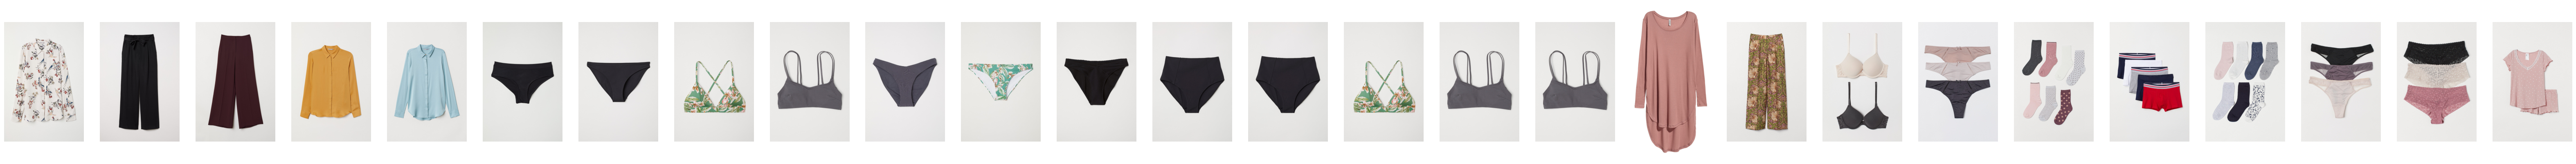

In [ ]:
plot_items(prev_items.values)

In [ ]:
plot_items(preds)

<Figure size 0x1000 with 0 Axes>